# Phrase Classification

This notebook contains code used to train and evaluate the classifier used as a $\textit{grounding function}$ for the two hand-coded teaching models.

It trains a simple logistic regression based on a TF-IDF of the tokens. Data comes from a pilot collection run with similar experiment structure. See Appendix $\textbf{Training a Phrase Classifier}$ for more details.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

## Load hand-labeled chats

In [17]:
label_df = pd.read_csv("data/pilot_chat_messages_labels.csv")
label_df["phrase"] = label_df.apply(lambda x: x["chat"] if pd.isnull(x["phrase"]) else x["phrase"], axis=1)
label_df.drop("Unnamed: 0", inplace=True, axis=1)

label_df["feature_list"] = label_df["features"].str.split(", ")
label_df["feature_list"] = label_df["feature_list"].apply(lambda d: d if isinstance(d, list) else [])

label_df = label_df[["task_uuid", "level_number", "phrase", "reference_type", "valence"]]

label_df.head()

,task_uuid,level_number,phrase,reference_type,valence
0,A3GIIL73GE2CBQ:3M0NZ3JDP3M4K1RM3VSSEUX29KUZ5O,6.0,:(,trajectory,negative
1,A3GIIL73GE2CBQ:3M0NZ3JDP3M4K1RM3VSSEUX29KUZ5O,9.0,:),trajectory,positive
2,A2MWAXV1YRK5GH:3AWETUDC94GGWPM1AFBM3317E60ZIY,10.0,4 white circles on the right would've given 20pts,features,positive
3,A31XNLA9REVGXL:33LKR6A5KG89A7H4WG1YPGJ4C841TT,6.0,5 in the middle of the three.,object_spatial,positive
4,A31XNLA9REVGXL:33LKR6A5KG89A7H4WG1YPGJ4C841TT,6.0,10 right below where you finished,object_behavior,positive


In [18]:
label_df.task_uuid.nunique()

81

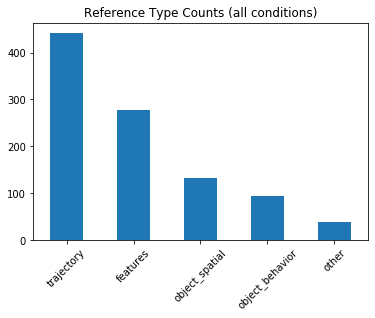

In [3]:
ax = label_df.reference_type.value_counts().plot(kind="bar", title="Reference Type Counts (all conditions)")
plt.setp(ax.get_xticklabels(), rotation=45);

In [4]:
for phrase_type in label_df.reference_type.unique():
    
    random_phrases = label_df[label_df.reference_type == phrase_type].phrase.sample(5)
    print("\nPhrase Type: {}".format(phrase_type))
    for p in random_phrases:
        print("\t{}".format(p))



Phrase Type: trajectory
	Bravo!
	The highest scores were in the area you chose. 
	Good job
	but still good job
	That was the most valuable point on the board.

Phrase Type: features
	yes circles are good
	purple circles seem to be worth the most so far
	triangles 0
	blue in the lower left is positve
	squres negative

Phrase Type: object_spatial
	Get all the blocks in the left hand lower corner
	there are lots of negative ones in each corner. hard to tell which ones they are
	In the bottom left there are three 8s and two 0s.
	bottom right would have been a little better because there were 3 vs 2
	lower left was a little better.

Phrase Type: object_behavior
	You got the highest point valued shape! 
	There was a mix of high value and - there, but it worked.
	Last one was -8. 
	First collected: 0 
	that was the best corner

Phrase Type: other
	But just keep going, half way there.
	Keep at it.
	once again! 
	They changed the colors?
	Well I was wrong


# Utterance Classification

Use a TF-IDF on the vocab, then train a basic logistic regression on the classes.

In [5]:
label_df.reference_type.value_counts()

trajectory         442
features           277
object_spatial     132
object_behavior     93
other               38
Name: reference_type, dtype: int64

In [6]:
def preprocess_chat_phrase(chat_phrase):
    
    # Remove punctuation
    chat_phrase = chat_phrase.translate(str.maketrans('', '', string.punctuation))
    chat_tokens = nltk.word_tokenize(chat_phrase)

    # Lemmaize and filter the words 
    chat_tokens = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in chat_tokens]
    chat_tokens = [t for t in chat_tokens if t not in stopwords.words("english")]
    
    # Convert single-digit numerals to words, i.e. "0" --> "zero"
    number_map = {"0":"zero","1":"one","2":"two","3":"three", 
                  "4": "four","5":"five", "6": "six", "7":"seven", 
                  "8":"eight", "9":"nine"}

    chat_tokens = [number_map.get(t, t) for t in chat_tokens]
    
    return " ".join(chat_tokens)

In [7]:
classifier_df = label_df.copy()

classifier_df['reference_id'] = classifier_df['reference_type'].factorize()[0]

category_to_id = dict(classifier_df[['reference_type', 'reference_id']].drop_duplicates().values)
id_to_category = dict(classifier_df[['reference_id', 'reference_type']].drop_duplicates().values)

classifier_df["preprocessed_phrase"] = classifier_df.apply(lambda x: preprocess_chat_phrase(x["phrase"]), axis=1)

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(classifier_df.preprocessed_phrase).toarray()
labels = classifier_df.reference_id

In [9]:
N = 3
for reference_type, reference_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == reference_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(reference_type))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> features:
  * Most Correlated Unigrams are: pink, yellow, circle
  * Most Correlated Bigrams are: circle worth, white circle, yellow circle

==> object_behavior:
  * Most Correlated Unigrams are: second, zero, collected
  * Most Correlated Bigrams are: best corner, symbol collected, second collected

==> object_spatial:
  * Most Correlated Unigrams are: upper, left, right
  * Most Correlated Bigrams are: upper right, right corner, lower right

==> other:
  * Most Correlated Unigrams are: got, color, round
  * Most Correlated Bigrams are: great job, good job, corner wa

==> trajectory:
  * Most Correlated Unigrams are: good, great, job
  * Most Correlated Bigrams are: yellow circle, great job, good job


In [10]:
X = classifier_df.preprocessed_phrase
y = classifier_df.reference_id

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [11]:
classifier_df.reference_type.value_counts()

trajectory         442
features           277
object_spatial     132
object_behavior     93
other               38
Name: reference_type, dtype: int64

In [12]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, 
                                                               y, 
                                                               classifier_df.index, test_size=0.15, 
                                                               random_state=1)

fitted_vectorizer = tfidf.fit(X_train)
train_vectors = fitted_vectorizer.transform(X_train)

final_model = LogisticRegression()
final_model.fit(train_vectors, y_train)

y_train.value_counts()

0    381
1    228
2    114
3     79
4     32
Name: reference_id, dtype: int64

In [13]:
test_vectors = fitted_vectorizer.transform(X_test)
y_pred = final_model.predict(test_vectors)

In [20]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= classifier_df['reference_type'].unique()))

				CLASSIFICATIION METRICS

                 precision    recall  f1-score   support

     trajectory       0.84      0.95      0.89        61
       features       0.96      0.96      0.96        49
 object_spatial       0.82      0.78      0.80        18
object_behavior       0.80      0.57      0.67        14
          other       0.67      0.33      0.44         6

       accuracy                           0.87       148
      macro avg       0.82      0.72      0.75       148
   weighted avg       0.87      0.87      0.86       148



In [22]:
final_metrics = metrics.classification_report(y_test, y_pred, 
                                    target_names= classifier_df['reference_type'].unique())

final_metrics

'                 precision    recall  f1-score   support\n\n     trajectory       0.84      0.95      0.89        61\n       features       0.96      0.96      0.96        49\n object_spatial       0.82      0.78      0.80        18\nobject_behavior       0.80      0.57      0.67        14\n          other       0.67      0.33      0.44         6\n\n       accuracy                           0.87       148\n      macro avg       0.82      0.72      0.75       148\n   weighted avg       0.87      0.87      0.86       148\n'

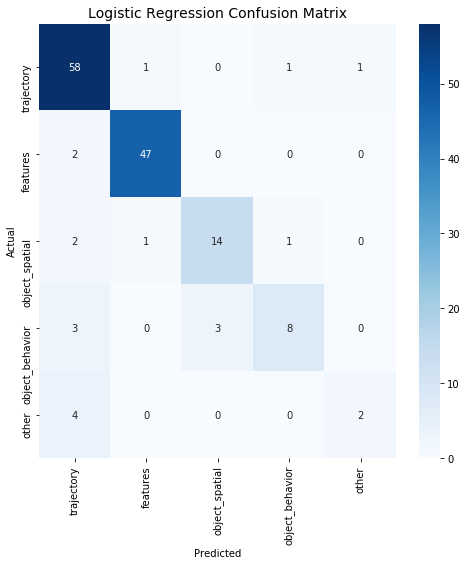

In [15]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=classifier_df.reference_type.unique(), 
            yticklabels=classifier_df.reference_type.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Logistic Regression Confusion Matrix", size=14);